# load common Python modules

In [1]:
import numpy

import matplotlib, matplotlib.pyplot

# some matplotlib parameters to make figures look nice
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'axes.labelsize':20})

In [2]:
import numpy
import matplotlib, matplotlib.pyplot

# install modules related to cobra

In [3]:
!pip install rich==6.2.0
!pip install cobra

In [4]:
import cobra.test
from cobra import Model, Reaction, Metabolite
from cobra.util.solver import linear_reaction_coefficients

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# load *E. coli* model

In [6]:
import cobra.test
import os
from os.path import join

data_dir = cobra.test.data_dir

print("mini test files: ")
print(", ".join(i for i in os.listdir(data_dir)
                if i.startswith("mini")))


mini test files: 
mini_fbc2.xml.gz, mini_fbc2.xml, mini.mat, mini.pickle, mini_cobra.xml, mini.yml, mini_fbc1.xml, mini.json, mini_fbc2.xml.bz2


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
model = cobra.io.read_sbml_model(join(data_dir, "/content/drive/MyDrive/Colab Notebooks/MODEL1507180046_url.xml"))
model_copy = model

In [9]:
model.objective = "Ec_biomass_SynAuto"
model.reactions.get_by_id("EX_photon_e").lower_bound = -100 
model.reactions.get_by_id("EX_glc_DASH_D_e").lower_bound = 0
model.reactions.get_by_id("EX_hco3_e").lower_bound = -3.7



# double-KO analysis

Generally, a single knockdown is not going to lead to some mutant that has growth-coupled production of a compound of interest. Knocking down two or more genes at once may do the trick. 

Here, we will focus on the reactions themselves, rather than the genes. We can overlay this to the genes, since we can find the genes associated with the reactions in the metabolic model through Gene-Protein-Reaction rules. 

Thus, we will define a function that iterates through the list of reactions present in our model, and creates all pairs possible (2 reactions). 

In [10]:
def get_pairs(rxns):

  """
  Returns a list of reaction pairs from rxns
  """

  working_pairs = []
  for i in range(len(rxns)):
    for j in range(len(rxns)):
      if i < j:
        pair = (str(rxns[i].id), str(rxns[j].id))
        working_pairs.append(pair)

  return working_pairs

Define a function to find the pair of reactions that when inhibited, the minimal production of the compound of interest is as high as possible when the biomass objective is maximized (OptKnock-ish)

In [21]:
def find_best_pair(chemical, rxns):

  pairs = get_pairs(rxns)
  table = []
  max_min = 0
  chosen_pair = []
  
  print('about to generate {} in silico KOs from {} testing reactions'.format(len(pairs), len(rxns)))

  for r1, r2 in pairs:
    model = cobra.io.read_sbml_model(join(data_dir, "/content/drive/MyDrive/Colab Notebooks/MODEL1507180046_url.xml"))
    model.objective = "Ec_biomass_SynAuto"
    model.reactions.get_by_id("EX_photon_e").lower_bound = -100 
    model.reactions.get_by_id("EX_glc_DASH_D_e").lower_bound = 0
    model.reactions.get_by_id("EX_hco3_e").lower_bound = -3.7
    model.add_boundary(model.metabolites.get_by_id("g3p_c"), type="demand")


    print('\t working with pair {} {}'.format(r1, r2))
    model.reactions.get_by_id(r1).lower_bound = 0
    model.reactions.get_by_id(r1).upper_bound = 0
    model.reactions.get_by_id(r2).lower_bound = 0
    model.reactions.get_by_id(r2).upper_bound = 0

    sol = model.optimize()
    if sol.status != 'optimal':
      Vbio_max = 0
    else:
      Vbio_max = sol.objective_value #Try to get the objective value (objective = Biomass)
    model.objective = chemical #set objective to target given chemical
    model.reactions.get_by_id('Ec_biomass_SynAuto').lower_bound = Vbio_max
    maximum = model.optimize(objective_sense='maximize').objective_value
    minimum = model.optimize(objective_sense='minimize').objective_value
    
    if minimum > max_min:
      chosen_pair = [r1, r2, Vbio_max, minimum, maximum]
      max_min = minimum
      print('\t\t new double KO ({} {}) found, with biomass production of {:.4f} and range [{:.4f}, {:.4f}]'.format(r1, r2, Vbio_max, minimum, maximum))
  
  if not chosen_pair:
    print('\t no growth-coupled design found :-(')
  else:
    print('\t best double KO found: {}'.format(chosen_pair))
  
  return chosen_pair

Remove all transport and exchange reactions from the list of reactions to use. Also, remove the reactions that cause complete inhibition of growth. The optimization procedure in 'find_best_pair' is a relatively intense procedure, so we want as few possible reactions present. 

In [12]:
def filter_reactions(model):
  with model:
    reactions_to_remove = [] #Clean list
    for reaction in model.reactions: #Iterate over the reactions
      model2 = model.copy()
      id = reaction.id #Get the ID, e.g. 'EX_ac_e'
      if id[0:3] == 'EX_': #if the first letters are EX_ (exhange), remove it 
        reactions_to_remove.append(id)
      elif id[-3:] == 'tex':
        reactions_to_remove.append(id)
      elif id[0:3] == 'Ec_':
        reactions_to_remove.append(id)
      else:
        model2.reactions.get_by_id(reaction.id).lower_bound = 0
        model2.reactions.get_by_id(reaction.id).upper_bound = 0
        sol_tmp = model2.optimize()
        if sol_tmp.objective_value < 1e-4:
          reactions_to_remove.append(id)
  model3 = model.copy()
  model3.remove_reactions(reactions_to_remove) #Remove those reactions
  rxns = model3.reactions #DictList of reactions after removal. 
  return rxns

Now use the functions to find the "best" growth-coupled design for our model:

In [18]:

model.add_boundary(model.metabolites.get_by_id("g3p_c"), type="demand")
chemicals = ['DM_g3p_c']

ValueError: ignored

In [16]:
# what chemical do we want to produce in our model? Examples are 'EX_ac_e', 'EX_lac__D_e', 'EX_succ_e', 'EX_etoh_e'


# Identify the reactions of interest:
rxns_to_test = filter_reactions(model)
print('selected {} reactions to work with...'.format(len(rxns_to_test)))

selected 256 reactions to work with...


In [ ]:
%%time
# find the best growth-coupled design
#rxns_to_test = rxns_to_test[:10]
rxns_to_test = rxns_to_test
chemicals = ['DM_g3p_c']
best_pair = find_best_pair(chemicals[0], rxns_to_test) 

about to generate 25425 in silico KOs from 226 testing reactions
	 working with pair CBFCu CBMK
	 working with pair CBFCu CBPS
	 working with pair CBFCu FQR
	 working with pair CBFCu CPPPGO2
	 working with pair CBFCu CSND
	 working with pair CBFCu CTPS1
	 working with pair CBFCu CTPS2
	 working with pair CBFCu CYPHYC
	 working with pair CBFCu CYPHYS
	 working with pair CBFCu CYSTA
	 working with pair CBFCu CYSTRS
	 working with pair CBFCu CYTBDu
	 working with pair CBFCu CYTK1
	 working with pair CBFCu DASYN183_LPAREN_6_9_12_RPAREN_
	 working with pair CBFCu DASYN184_LPAREN_6_9_12_15_RPAREN_
	 working with pair CBFCu DBTSr
	 working with pair CBFCu DCTPD
	 working with pair CBFCu DCTPD2
	 working with pair CBFCu DDPGA
	 working with pair CBFCu DPGM
	 working with pair CBFCu DRBK
	 working with pair CBFCu DRPA
	 working with pair CBFCu EHGLAT
	 working with pair CBFCu ENO
	 working with pair CBFCu FBA
	 working with pair CBFCu FBA2
	 working with pair CBFCu FBA3
	 working with pair CBFC

## double-KO results analysis

Lets have a look at our best pair:

In [61]:
best_pair

['CYTBDu',
 'DASYN184_LPAREN_6_9_12_15_RPAREN_',
 0.0,
 3.631354476378144e-15,
 1.2333333333333418]

Plot the WT (non-perturbed) production of biomass vs production of compound (black) and the reaction pair knockout (perturbed) production of biomass vs production of compound (red):

In [62]:
model = cobra.io.read_sbml_model(join(data_dir, "/content/drive/MyDrive/Colab Notebooks/MODEL1507180046_url.xml"))
model.reactions.get_by_id("EX_photon_e").lower_bound = -100 
model.reactions.get_by_id("EX_glc_DASH_D_e").lower_bound = 0
model.reactions.get_by_id("EX_hco3_e").lower_bound = -3.7
model.add_boundary(model.metabolites.get_by_id("g3p_c"), type="demand")
model_copy = model
baseline_growth = model.optimize().objective_value
wild_xs = [] ; wild_ys = []
bm_range = numpy.linspace(0, baseline_growth, 100)
model.objective = "DM_g3p_c"
for bm in bm_range:
  model.reactions.get_by_id('Ec_biomass_SynAuto').lower_bound = bm
  model.reactions.get_by_id('Ec_biomass_SynAuto').upper_bound = bm
  sol = model.optimize()
  if sol.status == 'optimal':
    wild_xs.append(bm)
    wild_ys.append(sol.objective_value)

/usr/local/lib/python3.7/dist-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [64]:
mins = []; maxs=[]
test_model = cobra.io.read_sbml_model(join(data_dir, "/content/drive/MyDrive/Colab Notebooks/MODEL1507180046_url.xml"))
test_model.reactions.get_by_id("EX_photon_e").lower_bound = -100 
test_model.reactions.get_by_id("EX_glc_DASH_D_e").lower_bound = 0
test_model.reactions.get_by_id("EX_hco3_e").lower_bound = -3.7
test_model.add_boundary(model.metabolites.get_by_id("g3p_c"), type="demand")
test_model.remove_reactions([best_pair[0], best_pair[1]])
sol_test = test_model.optimize().objective_value

sol_test_range = numpy.linspace(0, sol_test, 25)
test_model.objective = chemicals[0] 
for bm in sol_test_range:
  test_model.reactions.get_by_id('Ec_biomass_SynAuto').lower_bound = bm
  maxs.append(test_model.optimize(objective_sense='maximize').objective_value)
  mins.append(test_model.optimize(objective_sense='minimize').objective_value)

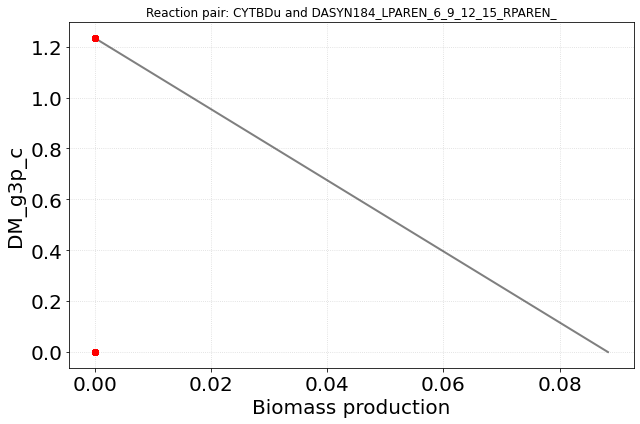

In [65]:
matplotlib.pyplot.figure(figsize=(9, 6))

matplotlib.pyplot.plot(wild_xs, wild_ys, color='black', lw=2, alpha=0.5)
matplotlib.pyplot.plot(sol_test_range, mins, 'o-', color='red', lw=2, alpha=0.5)
matplotlib.pyplot.plot(sol_test_range, maxs, 'o-', color='red', lw=2, alpha=0.5)

matplotlib.pyplot.xlabel('Biomass production')
matplotlib.pyplot.ylabel(chemicals[0])
matplotlib.pyplot.title('Reaction pair: ' + best_pair[0]+ ' and ' + best_pair[1])

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [66]:
test_model = cobra.io.read_sbml_model(join(data_dir, "/content/drive/MyDrive/Colab Notebooks/MODEL1507180046_url.xml"))
test_model.reactions.get_by_id("EX_photon_e").lower_bound = -100 
test_model.reactions.get_by_id("EX_glc_DASH_D_e").lower_bound = 0
test_model.reactions.get_by_id("EX_hco3_e").lower_bound = -3.7
test_model.add_boundary(model.metabolites.get_by_id("g3p_c"), type="demand")
test_model.objective = "DM_g3p_c"
print(test_model.optimize())
print(test_model.summary())
model_perturbed = test_model

with model_perturbed:
  model_perturbed.objective = "DM_g3p_c"
  model_perturbed.reactions.get_by_id('CYTBDu').lower_bound = 0
  model_perturbed.reactions.get_by_id('CYTBDu').upper_bound = 0
  model_perturbed.reactions.get_by_id('DASYN184_LPAREN_6_9_12_15_RPAREN_').lower_bound = 0
  model_perturbed.reactions.get_by_id('DASYN184_LPAREN_6_9_12_15_RPAREN_').upper_bound = 0
  print(model_perturbed.optimize())

print(model_perturbed.summary())



<Solution 1.233 at 0x7f2d34025b10>
Objective
1.0 DM_g3p_c = 1.2333333333331136

Uptake
------
Metabolite     Reaction  Flux  C-Number   C-Flux
       h_e       EX_h_e   3.7         0    0.00%
    hco3_e    EX_hco3_e   3.7         1  100.00%
  photon_e  EX_photon_e 32.89         0    0.00%
      pi_e      EX_pi_e 1.233         0    0.00%

Secretion
---------
Metabolite  Reaction   Flux  C-Number   C-Flux
     g3p_c  DM_g3p_c -1.233         3  100.00%
     h2o_e  EX_h2o_e -1.233         0    0.00%
      o2_e   EX_o2_e   -3.7         0    0.00%

<Solution 1.233 at 0x7f2d3391f110>
Objective
1.0 DM_g3p_c = 1.2333333333333392

Uptake
------
Metabolite     Reaction  Flux  C-Number   C-Flux
       h_e       EX_h_e   3.7         0    0.00%
    hco3_e    EX_hco3_e   3.7         1  100.00%
  photon_e  EX_photon_e 32.89         0    0.00%
      pi_e      EX_pi_e 1.233         0    0.00%

Secretion
---------
Metabolite  Reaction   Flux  C-Number   C-Flux
     g3p_c  DM_g3p_c -1.233         3  100.0